# Multiclass Classification - single_model using Naive Bayes(tfIdf)

# Importing and Preprocessing

## Importing libraries

In [1]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

## Importing files

In [2]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv' ,dtype = {'question_number':str})
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

## Preprocessing

In [3]:
df = original_data.copy()

#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

# Gathering required features

In [4]:
short_df = df[['question_id','question','student_answer','student_modified','ref_modified' ,'grade']]
short_df['grades_round']= short_df['grade'].apply(lambda x: round(x))

# Bag of words

In [5]:
# Tf-idf creation
Tf = TfidfVectorizer()
tfidf_vector = Tf.fit_transform(df['student_modified'])
tfidf_vector = tfidf_vector.toarray()

X = tfidf_vector
Y = short_df['grades_round'].values

# Seeding

In [6]:
#getting the seed index
classes = short_df['grades_round'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['grades_round'][short_df['grades_round']==i].index[0])
seed_index

[0, 1, 4, 5, 52, 94]

In [27]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = int(len(X)/5)
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
#     print("\nQ: ", act_data.loc[int(query_idx),'question'])
#     print("A: ",act_data.loc[int(query_idx),'student_answer'])
#     print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
#     human_label = int(input("\nGive me a grade 0 or 1:"))
    
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X_pool, y_pool))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X_pool, y_pool)))
print("======================================")
print("By just labelling ",round(n_queries*100.0/len(X),2),"% of total data accuracy of ", round(learner.score(X_pool, y_pool),3), " % is achieved on the unseen data"  )

Accuracy after query no. 1: 0.010267
Accuracy after query no. 2: 0.074363
Accuracy after query no. 3: 0.508015
Accuracy after query no. 4: 0.507812
Accuracy after query no. 5: 0.508021
Accuracy after query no. 6: 0.507819
Accuracy after query no. 7: 0.508028
Accuracy after query no. 8: 0.508237
Accuracy after query no. 9: 0.508447
Accuracy after query no. 10: 0.506595
Accuracy after query no. 11: 0.506804
Accuracy after query no. 12: 0.507838
Accuracy after query no. 13: 0.494841
Accuracy after query no. 14: 0.505780
Accuracy after query no. 15: 0.508055
Accuracy after query no. 16: 0.508264
Accuracy after query no. 17: 0.508475
Accuracy after query no. 18: 0.508685
Accuracy after query no. 19: 0.508068
Accuracy after query no. 20: 0.508278
Accuracy after query no. 21: 0.503106
Accuracy after query no. 22: 0.482187
Accuracy after query no. 23: 0.443431
Accuracy after query no. 24: 0.443615
Accuracy after query no. 25: 0.328494
Accuracy after query no. 26: 0.443568
Accuracy after query 

Accuracy after query no. 218: 0.507214
Accuracy after query no. 219: 0.506540
Accuracy after query no. 220: 0.501805
Accuracy after query no. 221: 0.501580
Accuracy after query no. 222: 0.493225
Accuracy after query no. 223: 0.492996
Accuracy after query no. 224: 0.493219
Accuracy after query no. 225: 0.493442
Accuracy after query no. 226: 0.493665
Accuracy after query no. 227: 0.490720
Accuracy after query no. 228: 0.498641
Accuracy after query no. 229: 0.498414
Accuracy after query no. 230: 0.496374
Accuracy after query no. 231: 0.498413
Accuracy after query no. 232: 0.509982
Accuracy after query no. 233: 0.517476
Accuracy after query no. 234: 0.520436
Accuracy after query no. 235: 0.520672
Accuracy after query no. 236: 0.520909
Accuracy after query no. 237: 0.525239
Accuracy after query no. 238: 0.525023
Accuracy after query no. 239: 0.527082
Accuracy after query no. 240: 0.527322
Accuracy after query no. 241: 0.527563
Accuracy after query no. 242: 0.527803
Accuracy after query no. 

Accuracy after query no. 429: 0.554061
Accuracy after query no. 430: 0.553838
Accuracy after query no. 431: 0.553616
Accuracy after query no. 432: 0.553892
Accuracy after query no. 433: 0.554169
Accuracy after query no. 434: 0.554446
Accuracy after query no. 435: 0.554723
Accuracy after query no. 436: 0.555000
Accuracy after query no. 437: 0.555278
Accuracy after query no. 438: 0.555556
Accuracy after query no. 439: 0.557336
Accuracy after query no. 440: 0.557114
Accuracy after query no. 441: 0.557393
Accuracy after query no. 442: 0.555165
Accuracy after query no. 443: 0.555444
Accuracy after query no. 444: 0.557731
Accuracy after query no. 445: 0.558011
Accuracy after query no. 446: 0.556784
Accuracy after query no. 447: 0.562594
Accuracy after query no. 448: 0.561871
Accuracy after query no. 449: 0.562154
Accuracy after query no. 450: 0.563444
Accuracy after query no. 451: 0.559194
Accuracy after query no. 452: 0.559476
Accuracy after query no. 453: 0.559254
Accuracy after query no. 

## Regular supervised task

In [13]:
from sklearn.model_selection import train_test_split

In [23]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [24]:
# logisticRegr = LogisticRegression()
nb.fit(X_train, Y_train)
score = nb.score(X_test, Y_test)

print(score)

0.5623721881390593


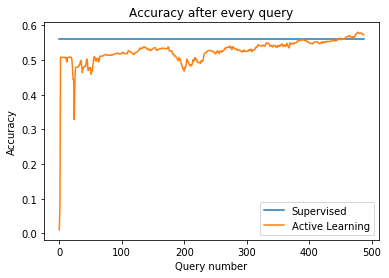

In [28]:
supervised_accuracy = [score for x in range(0,n_queries)]

plt.figure()
plt.plot(np.linspace(0,n_queries-1,n_queries),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()